In [2]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

from rich import print

In [3]:
full_df = pl.scan_csv("../data/dataframe_after_data_step.csv").collect()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

In [5]:
X = full_df.drop("churn").to_numpy()
y = full_df.select("churn").to_numpy().ravel()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [35]:
class ChurnDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [36]:
class ChurnPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32], dropout_rate=0.3):
        super().__init__()

        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.extend(
                [
                    nn.Linear(prev_dim, hidden_dim),
                    nn.BatchNorm1d(hidden_dim),
                    nn.ReLU(),
                    nn.Dropout(dropout_rate),
                ]
            )
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, 1))
        layers.append(nn.Sigmoid())

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x).squeeze()

In [37]:
train_dataset = ChurnDataset(X_train_scaled, y_train)
test_dataset = ChurnDataset(X_test_scaled, y_test)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ChurnPredictor(input_dim=X_train.shape[1]).to(
    device
)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=5, verbose=True
)

/Users/mamdouh_malaa/opt/miniconda3/envs/churn/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [56]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

In [57]:
from sklearn.metrics import accuracy_score


@torch.no_grad()
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    predictions = []
    targets = []

    for X_batch, y_batch in data_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)

        total_loss += loss.item()
        predictions.extend(y_pred.cpu().numpy())
        targets.extend(y_batch.cpu().numpy())

    predictions = np.array(predictions)
    targets = np.array(targets)

    return {
        "loss": total_loss / len(data_loader),
        "accuracy": accuracy_score(targets, predictions > 0.5),
        "roc_auc": roc_auc_score(targets, predictions),
        "predictions": predictions,
        "targets": targets,
    }

In [58]:
n_epochs = 50
best_val_auc = 0
best_model = None
early_stopping_patience = 10
no_improve_count = 0

In [59]:
import copy

train_losses = []
val_losses = []
val_accuracies = []
val_aucs = []

for epoch in range(n_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_metrics = evaluate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_metrics["loss"])
    val_accuracies.append(val_metrics["accuracy"])
    val_aucs.append(val_metrics["roc_auc"])

    scheduler.step(val_metrics["loss"])

    if val_metrics["roc_auc"] > best_val_auc:
        best_val_auc = val_metrics["roc_auc"]
        best_model = copy.deepcopy(model.state_dict())
        no_improve_count = 0
    else:
        no_improve_count += 1

    if no_improve_count >= early_stopping_patience:
        print(f"Early stopping triggered at epoch {epoch}")
        break

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}:")
        print(f"Train Loss: {train_loss:.4f}")
        print(f'Val Loss: {val_metrics["loss"]:.4f}')
        print(f'Val Accuracy: {val_metrics["accuracy"]:.4f}')
        print(f'Val ROC-AUC: {val_metrics["roc_auc"]:.4f}')
        print("-" * 50)

Epoch 5/50:

Train Loss: 0.2890

Val Loss: 0.2745

Val Accuracy: 0.9059

Val ROC-AUC: 0.9406

--------------------------------------------------

Epoch 10/50:

Train Loss: 0.2839

Val Loss: 0.2711

Val Accuracy: 0.9072

Val ROC-AUC: 0.9416

--------------------------------------------------

Epoch 15/50:

Train Loss: 0.2821

Val Loss: 0.2706

Val Accuracy: 0.9083

Val ROC-AUC: 0.9418

--------------------------------------------------

Epoch 20/50:

Train Loss: 0.2812

Val Loss: 0.2698

Val Accuracy: 0.9077

Val ROC-AUC: 0.9415

--------------------------------------------------

Epoch 25/50:

Train Loss: 0.2809

Val Loss: 0.2693

Val Accuracy: 0.9083

Val ROC-AUC: 0.9416

--------------------------------------------------

Early stopping triggered at epoch 28

In [60]:
model.load_state_dict(best_model)
final_metrics = evaluate(model, test_loader, criterion, device)

Final Test Metrics:

Accuracy: 0.9072

ROC-AUC: 0.9420

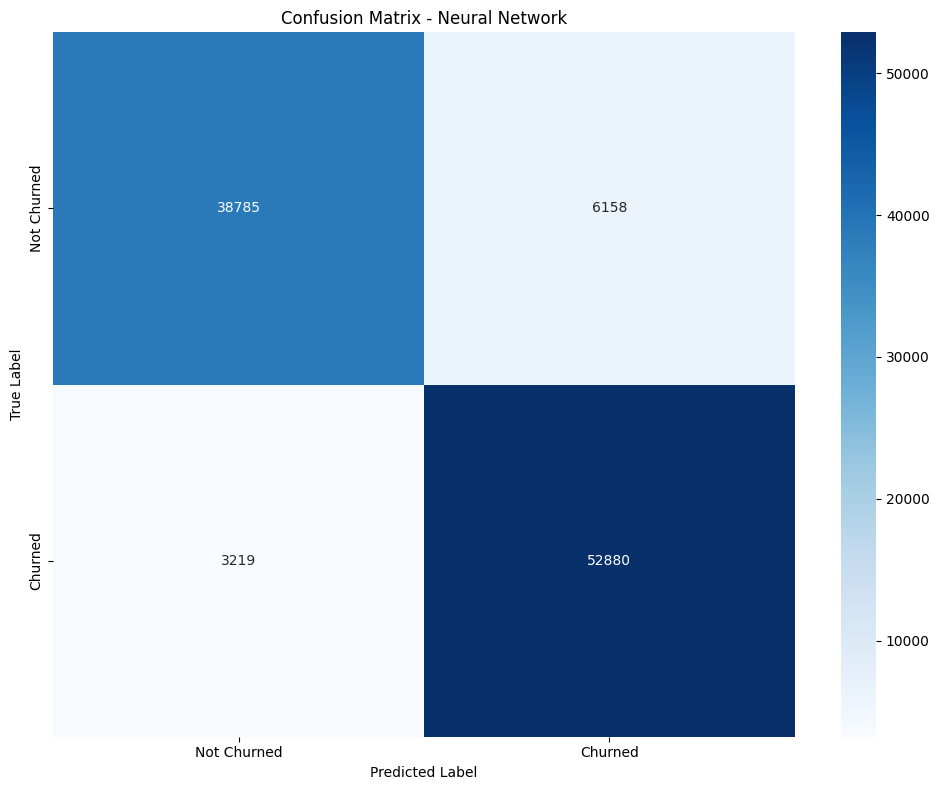

In [61]:
print("\nFinal Test Metrics:")
print(f'Accuracy: {final_metrics["accuracy"]:.4f}')
print(f'ROC-AUC: {final_metrics["roc_auc"]:.4f}')

cm = confusion_matrix(final_metrics["targets"], final_metrics["predictions"] > 0.5)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Not Churned", "Churned"],
    yticklabels=["Not Churned", "Churned"],
)
plt.title("Confusion Matrix - Neural Network")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

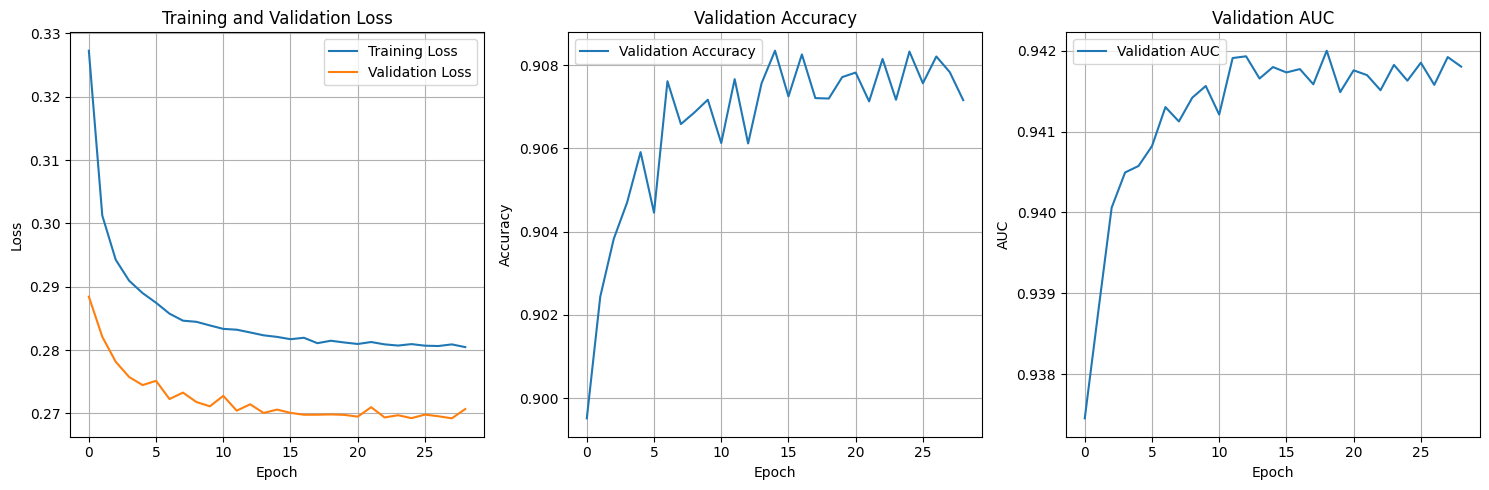

In [62]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(val_aucs, label="Validation AUC")
plt.title("Validation AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [88]:
from typing import OrderedDict
from pathlib import Path


def save_model(state_dict: OrderedDict):
    path = Path().absolute().parent
    path = path / "models" / "model.pth"
    torch.save(obj=state_dict, f=path)


save_model(model.state_dict())

In [83]:
def load_model() -> ChurnPredictor:
    path = Path().absolute().parent
    path = path / "models" / "model.pth"
    state_dict = torch.load(f=path)
    model = ChurnPredictor(input_dim=state_dict["model.0.weight"].shape[1])
    model.load_state_dict(state_dict=state_dict)
    return model